In [ ]:
import pandas as pd
from collections import defaultdict
import os
import numpy as np
pd.set_option('display.max_columns', None)
current_dir = os.getcwd()
# Parámetros
chunk_size = 100_000
total_data_path = os.path.join(current_dir, '../data/raw/total_data.csv')
target_rows = 1_000_000
min_items = 10  # Usar 5 productos por tienda
store_ids = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']

# Paso 1: Obtener fechas únicas
all_dates = set()
for chunk in pd.read_csv(total_data_path, chunksize=chunk_size, usecols=['date']):
    all_dates.update(chunk['date'].unique())
all_dates = sorted(list(all_dates))
D = len(all_dates)
print(f"Total de fechas únicas: {D}")

# Paso 2 y 3: Procesar cada tienda
all_filtered_data = []
for store_id_selected in store_ids:
    print(f"\nProcesando tienda: {store_id_selected}")
    item_date_counts = defaultdict(set)
    sales_by_item = defaultdict(float)

    # Identificar productos y sumar ventas
    for chunk in pd.read_csv(total_data_path, chunksize=chunk_size, usecols=['item_id', 'date', 'store_id', 'sales']):
        chunk['store_id'] = chunk['store_id'].astype(str)
        chunk_filtrado = chunk[chunk['store_id'] == store_id_selected]
        for item, date, sales in zip(chunk_filtrado['item_id'], chunk_filtrado['date'], chunk_filtrado['sales']):
            item_date_counts[item].add(date)
            sales_by_item[item] += sales

    # Filtrar productos que están en todas las fechas
    items_in_all_dates = [item for item, dates in item_date_counts.items() if len(dates) == D]
    if not items_in_all_dates:
        print(f"Ningún producto válido en {store_id_selected}. Se omite esta tienda.")
        continue

    # Seleccionar los top N productos por ventas
    sorted_items = sorted(items_in_all_dates, key=lambda x: sales_by_item[x], reverse=True)
    N = min(min_items, len(sorted_items))
    selected_items = sorted_items[:N]
    print(f"Seleccionados {N} productos con mayores ventas.")

    # Filtrar dataset
    filtered_data = []
    for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
        chunk['store_id'] = chunk['store_id'].astype(str)
        chunk_filtrado = chunk[
            (chunk['item_id'].isin(selected_items)) &
            (chunk['date'].isin(all_dates)) &
            (chunk['store_id'] == store_id_selected)
        ]
        filtered_data.append(chunk_filtrado)

    final_data_store = pd.concat(filtered_data, ignore_index=True)
    all_filtered_data.append(final_data_store)

# Concatenar datos
final_data = pd.concat(all_filtered_data, ignore_index=True)
final_data['date'] = pd.to_datetime(final_data['date'])

# Paso 4: Agrupar por trimestres
final_data['quarter'] = final_data['date'].dt.to_period('Q')  # Agrupa por trimestre (Q1, Q2, Q3, Q4)
quarterly_data = final_data.groupby(['item_id', 'store_id', 'quarter'])['sales'].sum().reset_index()

# Agregar características (opcional)
quarterly_data['quarter_num'] = quarterly_data['quarter'].dt.quarter  # Número del trimestre (1 a 4)
quarterly_data['year'] = quarterly_data['quarter'].dt.year
quarterly_data['rolling_mean_4'] = quarterly_data.groupby(['item_id', 'store_id'])['sales'].transform(
    lambda x: x.rolling(4, min_periods=1).mean()  # Media móvil de los últimos 4 trimestres
)

# Normalizar ventas (opcional)
quarterly_data['log_sales'] = np.log1p(quarterly_data['sales'])

# Reducir tamaño si es necesario
if len(quarterly_data) > target_rows:
    quarterly_data = quarterly_data.sort_values('quarter').head(target_rows)
    print(f"\nEl dataset ha sido reducido a {target_rows} filas.")

# Verificación
print(f"\nDataset final trimestral:")
print(f"Filas totales: {len(quarterly_data):,}")
print(f"Items únicos: {quarterly_data['item_id'].nunique()}")
print(f"Tiendas únicas: {quarterly_data['store_id'].nunique()}")
print(f"Trimestres únicos: {quarterly_data['quarter'].nunique()}")

# Guardar
output_path = os.path.join(current_dir, "../data/csv_model/models_10p_10s_cuartiles.csv")
quarterly_data.to_csv(output_path, index=False)

Total de fechas únicas: 1941

Procesando tienda: CA_1
Seleccionados 10 productos con mayores ventas.


/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=c


Procesando tienda: CA_2
Seleccionados 10 productos con mayores ventas.


/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=c


Procesando tienda: CA_3
Seleccionados 10 productos con mayores ventas.


/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=c


Procesando tienda: CA_4
Seleccionados 10 productos con mayores ventas.


/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=c


Procesando tienda: TX_1
Seleccionados 10 productos con mayores ventas.


/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=c


Procesando tienda: TX_2
Seleccionados 10 productos con mayores ventas.


/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=c


Procesando tienda: TX_3
Seleccionados 10 productos con mayores ventas.


/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=c


Procesando tienda: WI_1
Seleccionados 10 productos con mayores ventas.


/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=c


Procesando tienda: WI_2
Seleccionados 10 productos con mayores ventas.


/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=c


Procesando tienda: WI_3
Seleccionados 10 productos con mayores ventas.


/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/1995637324.py:51: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=c


Dataset final trimestral:
Filas totales: 2,200
Items únicos: 36
Tiendas únicas: 10
Trimestres únicos: 22


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

## LSTM

Epoch 1/100


/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_5381/3071538921.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(lstm_path, parse_dates=['quarter'])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 0.3094
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 0.0361
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 0.0382
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 0.0335
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0320  
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 0.0316
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 0.0289
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 0.0312
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 0.0300
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 0.0289
Epoch 11/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 0.0290
Epoch 12/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0288
Epoch 13/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 0.0323
Epoch 14/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 0.0284
Epoch 15/100
107/107 ━━━━━━━━

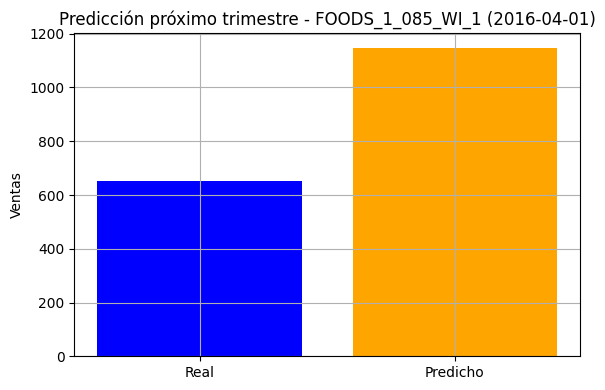

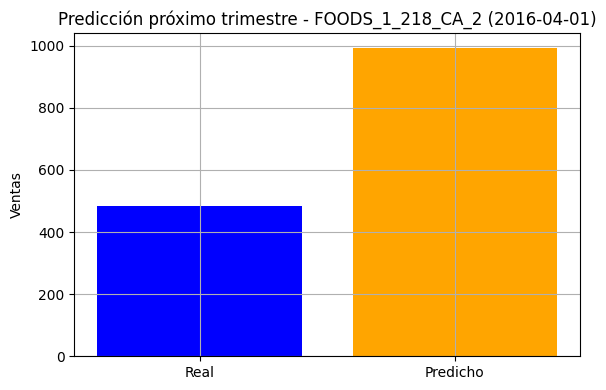

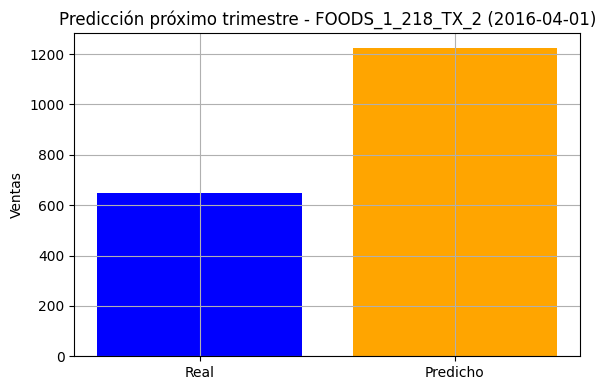

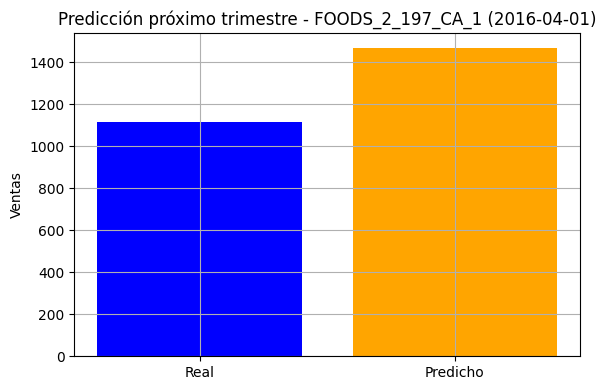

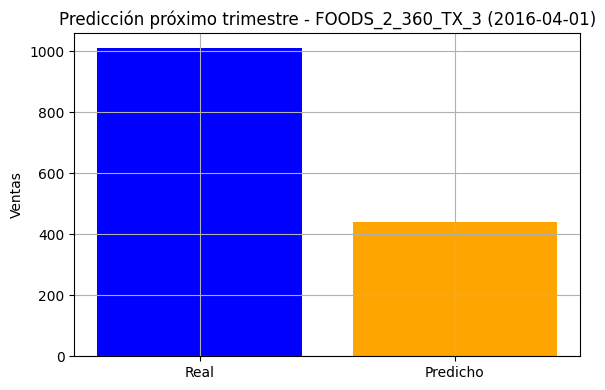


Primeras filas de los resultados:
         item_store     quarter  real_sales  predicted_sales
0  FOODS_1_085_WI_1  2016-04-01       653.0      1146.074998
1  FOODS_1_218_CA_2  2016-04-01       483.0       992.073645
2  FOODS_1_218_TX_2  2016-04-01       650.0      1222.995755
3  FOODS_2_197_CA_1  2016-04-01      1114.0      1467.286121
4  FOODS_2_360_TX_3  2016-04-01      1010.0       438.782721


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import os

# === Parámetros ===
N_STEPS = 4           # Ventana de entrada: 4 trimestres (1 año)
N_PRED = 1            # Predecir 1 trimestre
EPOCHS = 100          # Reducido porque los datos trimestrales son menos
BATCH_SIZE = 16
current_dir = os.getcwd()
lstm_path = os.path.join(current_dir, "../data/csv_model/models_10p_10s_cuartiles.csv")

# === 1. Cargar datos trimestrales ===
df = pd.read_csv(lstm_path, parse_dates=['quarter'])
df['quarter'] = df['quarter'].astype(str)  # Asegurar que 'quarter' sea string para visualización
# Ordenar por quarter
df = df.sort_values(['item_id', 'store_id', 'quarter']).reset_index(drop=True)

# === 2. Preprocesamiento ===
# Usar log_sales para estabilizar la varianza (o 'sales' si prefieres)
sales_col = 'log_sales'  # Alternativa: 'sales'
# Escalar datos por cada combinación de item_id y store_id
scalers = {}
for (item_id, store_id), group in df.groupby(['item_id', 'store_id']):
    scaler = MinMaxScaler()
    df.loc[(df['item_id'] == item_id) & (df['store_id'] == store_id), 'scaled_sales'] = scaler.fit_transform(
        group[sales_col].values.reshape(-1, 1)
    ).flatten()
    scalers[(item_id, store_id)] = scaler

# === 3. Crear secuencias para todas las combinaciones ===
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

# Generar secuencias para entrenamiento
X_train, y_train = [], []
for (item_id, store_id), group in df.groupby(['item_id', 'store_id']):
    sales_scaled = group['scaled_sales'].values
    if len(sales_scaled) >= N_STEPS + 1:  # Asegurar suficientes datos
        X, y = create_sequences(sales_scaled[:-1], N_STEPS)  # Excluir el último trimestre para prueba
        if len(X) > 0:
            X_train.append(X)
            y_train.append(y)

# Concatenar todas las secuencias
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# === 4. Definir y entrenar modelo LSTM ===
model = Sequential([
    LSTM(64, activation='relu', input_shape=(N_STEPS, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

# === 5. Predecir el próximo trimestre para cada combinación ===
predictions = []
real_values = []
item_store_combinations = []
quarters = []

for (item_id, store_id), group in df.groupby(['item_id', 'store_id']):
    sales_scaled = group['scaled_sales'].values
    if len(sales_scaled) >= N_STEPS + 1:  # Asegurar suficientes datos
        # Última ventana para predicción
        input_seq = sales_scaled[-(N_STEPS+1):-1].reshape(1, N_STEPS, 1)
        # Predecir
        next_pred = model.predict(input_seq, verbose=0)[0][0]
        # Invertir escalado
        scaler = scalers[(item_id, store_id)]
        pred_sales = scaler.inverse_transform([[next_pred]])[0][0]
        if sales_col == 'log_sales':
            pred_sales = np.expm1(pred_sales)  # Invertir logaritmo
        # Valor real del último trimestre
        real_sales = group[sales_col].iloc[-1]
        if sales_col == 'log_sales':
            real_sales = np.expm1(real_sales)
        # Guardar resultados
        predictions.append(pred_sales)
        real_values.append(real_sales)
        item_store_combinations.append(f"{item_id}_{store_id}")
        quarters.append(group['quarter'].iloc[-1])

# === 6. Mostrar resultados ===
# Crear DataFrame con resultados
comparison_df = pd.DataFrame({
    'item_store': item_store_combinations,
    'quarter': quarters,
    'real_sales': real_values,
    'predicted_sales': predictions
})
# # Guardar resultados
# comparison_path = os.path.join(current_dir, "../data/csv_model/validation_next_quarter_10x10.csv")
# comparison_df.to_csv(comparison_path, index=False)

# === 4. Calcular métricas ===
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(real_values, predictions))
mae = mean_absolute_error(real_values, predictions)
r2 = r2_score(real_values, predictions)
print(f"\nResultados globales (ARIMA):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"r2: {r2:.2f}")

# Visualizar algunas combinaciones (por ejemplo, las primeras 5)
for i, (item_store, quarter, real, pred) in enumerate(zip(item_store_combinations[:5], quarters[:5], real_values[:5], predictions[:5])):
    plt.figure(figsize=(6,4))
    plt.bar(['Real', 'Predicho'], [real, pred], color=['blue', 'orange'])
    plt.title(f'Predicción próximo trimestre - {item_store} ({quarter})')
    plt.ylabel('Ventas')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Opcional: Imprimir tabla de resultados
print("\nPrimeras filas de los resultados:")
print(comparison_df.head())

## SARIMAX


Resultados globales (ARIMA):
RMSE: 1476.23
MAE: 1203.62
r2: -0.98


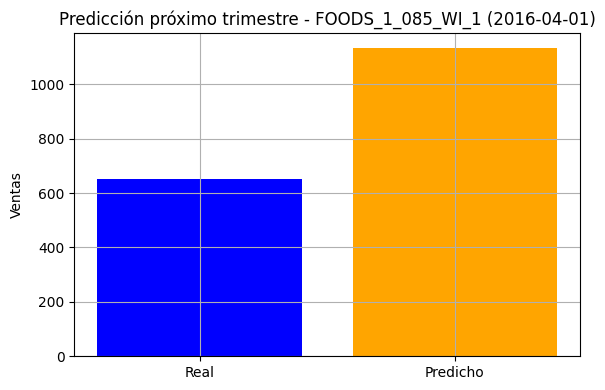

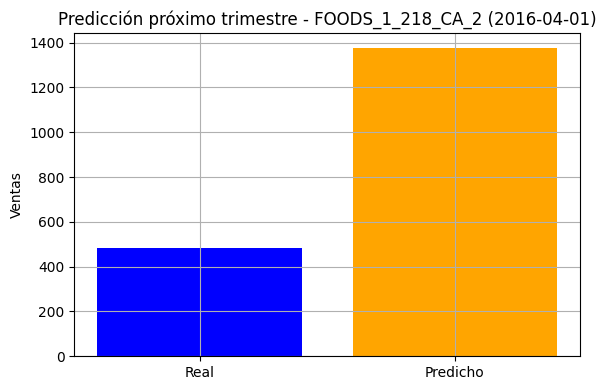

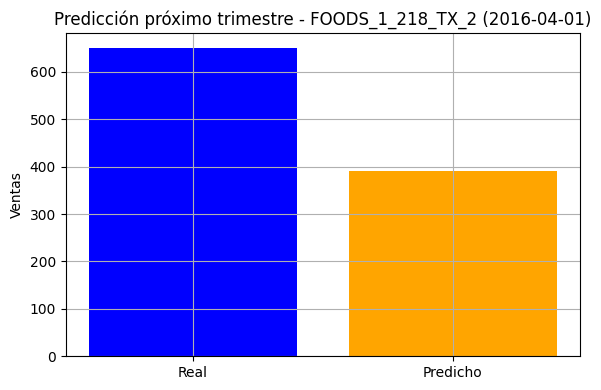

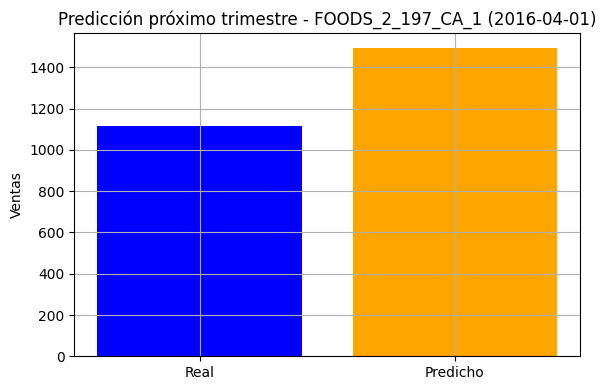

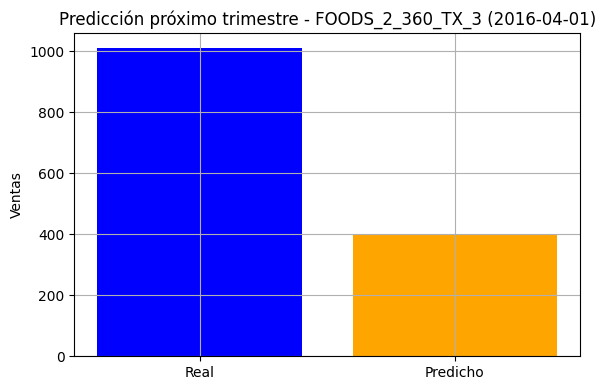


Primeras filas de los resultados:
         item_store     quarter  real_sales  predicted_sales
0  FOODS_1_085_WI_1  2016-04-01         653      1132.081052
1  FOODS_1_218_CA_2  2016-04-01         483      1374.947276
2  FOODS_1_218_TX_2  2016-04-01         650       390.484436
3  FOODS_2_197_CA_1  2016-04-01        1114      1492.901419
4  FOODS_2_360_TX_3  2016-04-01        1010       400.580387


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import os
import warnings
warnings.filterwarnings("ignore")  # Ignorar advertencias de convergencia de ARIMA

# === Parámetros ===
current_dir = os.getcwd()
lstm_path = os.path.join(current_dir, "../data/csv_model/models_10p_10s_cuartiles.csv")

# === 1. Cargar datos trimestrales ===
df = pd.read_csv(lstm_path, parse_dates=['quarter'])
df['quarter'] = df['quarter'].astype(str)  # Para visualización
df = df.sort_values(['item_id', 'store_id', 'quarter']).reset_index(drop=True)

# === 2. Predecir con ARIMA para cada combinación ===
predictions = []
real_values = []
item_store_combinations = []
quarters = []

for (item_id, store_id), group in df.groupby(['item_id', 'store_id']):
    sales = group['sales'].values  # Usar 'sales' directamente (o 'log_sales' con np.expm1 después)
    if len(sales) >= 5:  # Asegurar suficientes datos para ARIMA
        # Ajustar modelo SARIMA
        # (1,1,1)(1,1,1,4): ARIMA(1,1,1) con componente estacional de período 4 (trimestres por año)
        model = SARIMAX(sales[:-1], order=(1, 1, 1), seasonal_order=(1, 1, 1, 4))
        try:
            model_fit = model.fit(disp=False)
            # Predecir el próximo trimestre
            pred = model_fit.forecast(steps=1)[0]
            # Valor real del último trimestre
            real = sales[-1]
            # Guardar resultados
            predictions.append(pred)
            real_values.append(real)
            item_store_combinations.append(f"{item_id}_{store_id}")
            quarters.append(group['quarter'].iloc[-1])
        except:
            print(f"No se pudo ajustar el modelo para {item_id}_{store_id}")
            continue

# === 3. Crear DataFrame con resultados ===
comparison_df = pd.DataFrame({
    'item_store': item_store_combinations,
    'quarter': quarters,
    'real_sales': real_values,
    'predicted_sales': predictions
})

# # Guardar resultados
# comparison_path = os.path.join(current_dir, "../data/csv_model/validation_arima_next_quarter_10x10.csv")
# comparison_df.to_csv(comparison_path, index=False)

# === 4. Calcular métricas ===
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(real_values, predictions))
mae = mean_absolute_error(real_values, predictions)
r2 = r2_score(real_values, predictions)
print(f"\nResultados globales (ARIMA):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"r2: {r2:.2f}")

# === 5. Visualizar algunas combinaciones (primeras 5) ===
import matplotlib.pyplot as plt
for i, (item_store, quarter, real, pred) in enumerate(zip(item_store_combinations[:5], quarters[:5], real_values[:5], predictions[:5])):
    plt.figure(figsize=(6, 4))
    plt.bar(['Real', 'Predicho'], [real, pred], color=['blue', 'orange'])
    plt.title(f'Predicción próximo trimestre - {item_store} ({quarter})')
    plt.ylabel('Ventas')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Imprimir tabla de resultados
print("\nPrimeras filas de los resultados:")
print(comparison_df.head())

## Prophet

Importing plotly failed. Interactive plots will not work.
14:14:36 - cmdstanpy - INFO - Chain [1] start processing
14:14:37 - cmdstanpy - INFO - Chain [1] done processing
14:14:37 - cmdstanpy - INFO - Chain [1] start processing
14:14:37 - cmdstanpy - INFO - Chain [1] done processing
14:14:37 - cmdstanpy - INFO - Chain [1] start processing
14:14:37 - cmdstanpy - INFO - Chain [1] done processing
14:14:37 - cmdstanpy - INFO - Chain [1] start processing
14:14:37 - cmdstanpy - INFO - Chain [1] done processing
14:14:37 - cmdstanpy - INFO - Chain [1] start processing
14:14:37 - cmdstanpy - INFO - Chain [1] done processing
14:14:37 - cmdstanpy - INFO - Chain [1] start processing
14:14:37 - cmdstanpy - INFO - Chain [1] done processing
14:14:37 - cmdstanpy - INFO - Chain [1] start processing
14:14:37 - cmdstanpy - INFO - Chain [1] done processing
14:14:37 - cmdstanpy - INFO - Chain [1] start processing
14:14:37 - cmdstanpy - INFO - Chain [1] done processing
14:14:37 - cmdstanpy - INFO - Chain [1


📊 Evaluación del modelo (Prophet):
➡️  MSE:  2655657.96
➡️  MAE:  1255.15
➡️  R²:   -1.4164


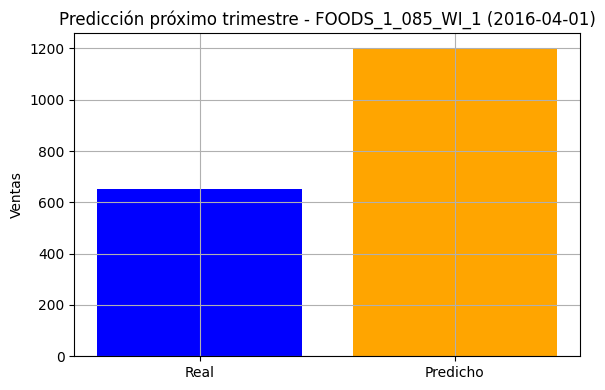

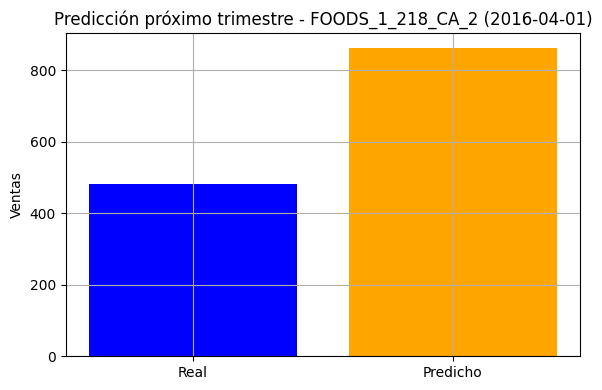

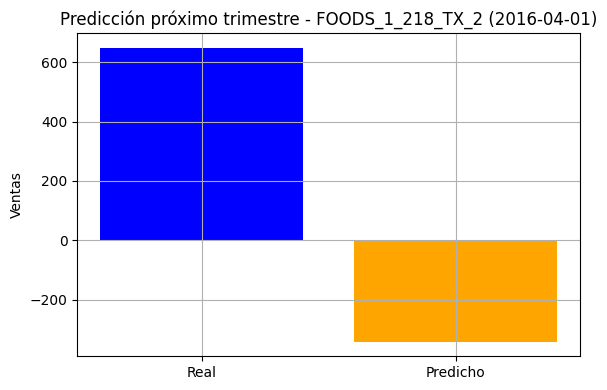

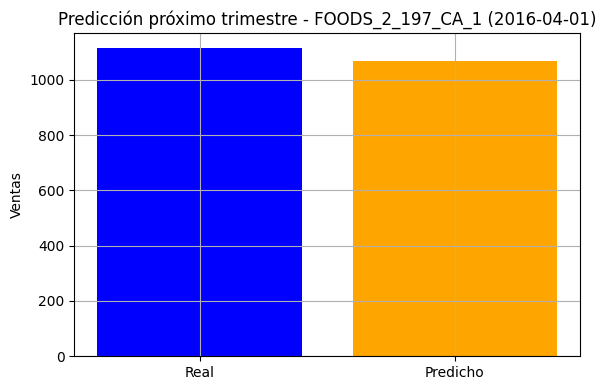

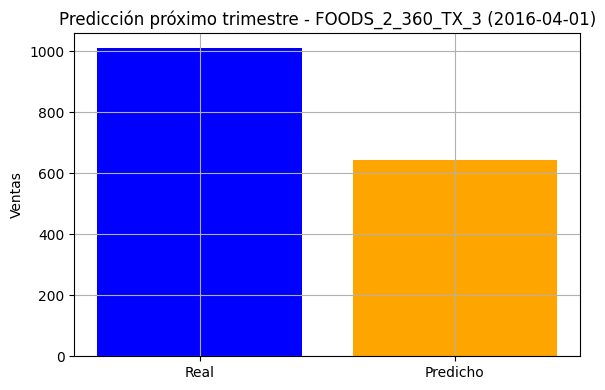


Primeras filas de los resultados:
         item_store     quarter  real_sales  predicted_sales
0  FOODS_1_085_WI_1  2016-04-01         653      1200.955075
1  FOODS_1_218_CA_2  2016-04-01         483       861.235916
2  FOODS_1_218_TX_2  2016-04-01         650      -341.786964
3  FOODS_2_197_CA_1  2016-04-01        1114      1068.581224
4  FOODS_2_360_TX_3  2016-04-01        1010       644.391056


In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Parámetros ===
current_dir = os.getcwd()
lstm_path = os.path.join(current_dir, "../data/csv_model/models_10p_10s_cuartiles.csv")

# === 1. Cargar datos trimestrales ===
df = pd.read_csv(lstm_path, parse_dates=['quarter'])
df['quarter'] = pd.to_datetime(df['quarter'].astype(str) + '-01')  # Convertir quarter a fecha (primer día del trimestre)
df = df.sort_values(['item_id', 'store_id', 'quarter']).reset_index(drop=True)

# === 2. Predecir con Prophet para cada combinación ===
predictions = []
real_values = []
item_store_combinations = []
quarters = []

for (item_id, store_id), group in df.groupby(['item_id', 'store_id']):
    # Preparar datos para Prophet (requiere columnas 'ds' y 'y')
    prophet_df = group[['quarter', 'sales']].rename(columns={'quarter': 'ds', 'sales': 'y'})
    if len(prophet_df) >= 5:  # Asegurar suficientes datos
        # Ajustar modelo Prophet
        model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
        model.fit(prophet_df[:-1])  # Excluir el último trimestre para validación
        # Crear DataFrame para predicción
        future = model.make_future_dataframe(periods=1, freq='Q')  # Predecir 1 trimestre
        forecast = model.predict(future)
        # Obtener predicción y valor real
        pred = forecast['yhat'].iloc[-1]
        real = prophet_df['y'].iloc[-1]
        # Guardar resultados
        predictions.append(pred)
        real_values.append(real)
        item_store_combinations.append(f"{item_id}_{store_id}")
        quarters.append(group['quarter'].iloc[-1].strftime('%Y-%m-%d'))

# === 3. Crear DataFrame con resultados ===
comparison_df = pd.DataFrame({
    'item_store': item_store_combinations,
    'quarter': quarters,
    'real_sales': real_values,
    'predicted_sales': predictions
})

# # Guardar resultados
# comparison_path = os.path.join(current_dir, "../data/csv_model/validation_prophet_next_quarter_10x10.csv")
# comparison_df.to_csv(comparison_path, index=False)

# === 4. Calcular métricas ===
mse = mean_squared_error(real_values, predictions)
mae = mean_absolute_error(real_values, predictions)
r2 = r2_score(real_values, predictions)

print(f"\n📊 Evaluación del modelo (Prophet):")
print(f"➡️  MSE:  {mse:.2f}")
print(f"➡️  MAE:  {mae:.2f}")
print(f"➡️  R²:   {r2:.4f}")

# === 5. Visualizar algunas combinaciones (primeras 5) ===
for i, (item_store, quarter, real, pred) in enumerate(zip(item_store_combinations[:5], quarters[:5], real_values[:5], predictions[:5])):
    plt.figure(figsize=(6, 4))
    plt.bar(['Real', 'Predicho'], [real, pred], color=['blue', 'orange'])
    plt.title(f'Predicción próximo trimestre - {item_store} ({quarter})')
    plt.ylabel('Ventas')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Imprimir tabla de resultados
print("\nPrimeras filas de los resultados:")
print(comparison_df.head())